In [1]:
import uproot, glob, os
import numpy as np
import numba,vector
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sys import getsizeof

In [2]:
# root_signal=glob.glob("/data/HH/pwgevents-01*.root")

In [3]:
root_signal=glob.glob("/data/HH/pwgevents-01*.root")

In [4]:
def getNeventsRoot(rootfiles):
    N=0
    for f in rootfiles:
        with uproot.open(f+':Delphes') as tree:
            N+=tree.num_entries
    return N

In [5]:
N_root_sig=getNeventsRoot(root_signal)
print(N_root_sig)

3272270


In [6]:
@numba.jit(nopython=True)
def checkHiggs(batch):
    higgs=np.full((len(batch),),False)
    for i in range(len(batch)):
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==25:
                higgs[i]=True
                break
    return higgs

In [7]:
@numba.jit(nopython=True)
def nTauDecays(batch):
    nTau=np.full((len(batch),),0)
    for i in range(len(batch)):
        n=0
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==16 and batch[i]['Particle.Status'][p]==1:
                nTau[i]+=1
    return nTau

In [8]:
@numba.jit(nopython=True)
def HHmass(batch):
    mass=np.full((len(batch),),0.)
    for i in range(len(batch)):
        higgses=[]
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==25:
                if batch[i]['Particle.Status'][p]==22:
                    higgses.append(vector.obj(pt=batch[i]['Particle.PT'][p], 
                                          phi=batch[i]['Particle.Phi'][p], 
                                          eta=batch[i]['Particle.Eta'][p], 
                                          mass=125.))
            if len(higgses)>1:
                break
        mass[i]=(higgses[0]+higgses[1]).mass
    return mass

In [9]:
@numba.jit(nopython=True)
def preselection(batch):
    pass_selection=np.full((len(batch),),False)
    for i in range(len(batch)):
        leptons=[] #start with emtpy list of objects
        charges=[]
        jets=[]
        
        ### 1st step: get all the 4-vectors of the objects which fulfill our preselection criteria ###
        
        #loop over electrons
        for e in range(len(batch[i]['Electron.PT'])):
            if batch[i]['Electron.PT'][e]>=10.0 and abs(batch[i]['Electron.Eta'][e])<2.5:
                leptons.append(vector.obj(pt=batch[i]['Electron.PT'][e], 
                                          phi=batch[i]['Electron.Phi'][e], 
                                          eta=batch[i]['Electron.Eta'][e], 
                                          mass=511./1e6))
                charges.append(batch[i]['Electron.Charge'][e])
        #loop over muons
        for m in range(len(batch[i]['Muon.PT'])):
            if batch[i]['Muon.PT'][m]>=10.0 and abs(batch[i]['Muon.Eta'][m])<2.5:
                leptons.append(vector.obj(pt=batch[i]['Muon.PT'][m], 
                                          phi=batch[i]['Muon.Phi'][m], 
                                          eta=batch[i]['Muon.Eta'][m], 
                                          mass=105.66/1e3))
                charges.append(batch[i]['Muon.Charge'][m])
                
        #loop over jets
        for j in range(len(batch[i]['Jet.PT'])):
              if batch[i]['Jet.PT'][j]>=25.0 and abs(batch[i]['Jet.Eta'][j])<2.5:  
                jets.append(vector.obj(pt=batch[i]['Jet.PT'][j], 
                                          phi=batch[i]['Jet.Phi'][j], 
                                          eta=batch[i]['Jet.Eta'][j], 
                                          mass=batch[i]['Jet.Mass'][j]))
        
        #skip events which fail
        if len(leptons)!=3 or len(jets)<2:
            continue
        
        #remove events which have wrong charge reconstruction
        if abs(sum(charges))==3:
            # print(charges)
            continue
        
        #keep the remaining ones
        pass_selection[i]=True

    
    return pass_selection

In [17]:
@numba.jit(nopython=True)
def get4vecs(batch):
    #does the event pass our selection?
    pass_selection=np.full((len(batch),),False)
    
    #define here the arrays for all variables
    DRl0l1=np.full((len(batch),),1000.)
    # met=np.zeros((len(batch),))

    l0_pt = []
    l0_phi = []
    l0_eta = []
    l0_mass = []

    l1_pt = []
    l1_phi = []
    l1_eta = []
    l1_mass = []

    l2_pt = []
    l2_phi = []
    l2_eta = []
    l2_mass = []

    j0_pt = []
    j0_phi = []
    j0_eta = []
    j0_mass = []

    j1_pt = []
    j1_phi = []
    j1_eta = []
    j1_mass = []

    met_pt = []
    met_phi = []
    met_eta = []
    met_mass = []
    
    #loop over the individual events in the batch
    for i in range(len(batch)):
        leptons=[] #start with emtpy list of objects
        charges=[]
        jets=[]
    
        ### 1st step: get all the 4-vectors of the objects which fulfill our preselection criteria ###
        
        #loop over electrons
        for e in range(len(batch[i]['Electron.PT'])):
            if batch[i]['Electron.PT'][e]>=10.0 and abs(batch[i]['Electron.Eta'][e])<2.5:
                leptons.append(vector.obj(pt=batch[i]['Electron.PT'][e], 
                                          phi=batch[i]['Electron.Phi'][e], 
                                          eta=batch[i]['Electron.Eta'][e], 
                                          mass=511./1e6))
                charges.append(batch[i]['Electron.Charge'][e])
        #loop over muons
        for m in range(len(batch[i]['Muon.PT'])):
            if batch[i]['Muon.PT'][m]>=10.0 and abs(batch[i]['Muon.Eta'][m])<2.5:
                leptons.append(vector.obj(pt=batch[i]['Muon.PT'][m], 
                                          phi=batch[i]['Muon.Phi'][m], 
                                          eta=batch[i]['Muon.Eta'][m], 
                                          mass=105.66/1e3))
                charges.append(batch[i]['Muon.Charge'][m])
                
        #loop over jets
        for j in range(len(batch[i]['Jet.PT'])):
              if batch[i]['Jet.PT'][j]>=25.0 and abs(batch[i]['Jet.Eta'][j])<2.5:  
                jets.append(vector.obj(pt=batch[i]['Jet.PT'][j], 
                                          phi=batch[i]['Jet.Phi'][j], 
                                          eta=batch[i]['Jet.Eta'][j], 
                                          mass=batch[i]['Jet.Mass'][j]))

        #skip events which fail
        if len(leptons)!=3 or len(jets)<2:
            continue

        #remove events which have wrong charge reconstruction
        if abs(sum(charges))==3:
            continue

        #keep the remaining ones
        pass_selection[i]=True
            
        #sort jets according to their pT (highest pT first)
        jets.sort(key=lambda p: p.pt,reverse=True)

        j0 = jets[0]
        j1 = jets[1]

        #sort leptons: l0 is the one with unique charge
        l0=leptons[0]
        if charges[0]==charges[1]:
            l0=leptons[2]
        elif charges[0]==charges[2]:
            l0=leptons[1]
        else:
            l0=leptons[0]

        #l1 is the one closest to l0 in deltaR
        minDR=1000.
        l1=leptons[0]
        for l in leptons:
            if l==l0:
                continue
            dR=l.deltaR(l0)
            if dR<minDR:
                l1=l
                minDR=dR

        #l2 is the remaining one
        for l in leptons:
            if l==l0 or l==l1: 
                continue
            l2=l

        met4vec = vector.obj(pt=batch[i]['MissingET.MET'][0], 
                                          phi=batch[i]['MissingET.Phi'][0], 
                                          eta=0, 
                                          mass=0)

        ####################################
        # 4 vecs
        ####################################

        l0_pt.append(l0.pt)
        l0_phi.append(l0.phi)
        l0_eta.append(l0.eta)
        l0_mass.append(l0.mass)
    
        l1_pt.append(l1.pt)
        l1_phi.append(l1.phi)
        l1_eta.append(l1.eta)
        l1_mass.append(l1.mass)
    
        l2_pt.append(l2.pt)
        l2_phi.append(l2.phi)
        l2_eta.append(l2.eta)
        l2_mass.append(l2.mass)
    
        j0_pt.append(j0.pt)
        j0_phi.append(j0.phi)
        j0_eta.append(j0.eta)
        j0_mass.append(j0.mass)
    
        j1_pt.append(j1.pt)
        j1_phi.append(j1.phi)
        j1_eta.append(j1.eta)
        j1_mass.append(j1.mass)
    
        met_pt.append(met4vec.pt)
        met_phi.append(met4vec.phi)
        met_eta.append(met4vec.eta)
        met_mass.append(met4vec.mass)

    #apply selection and return events

    return l0_pt,l0_phi,l0_eta,l0_mass,l1_pt,l1_phi,l1_eta,l1_mass,l2_pt,l2_phi,l2_eta,l2_mass,\
    j0_pt,j0_phi,j0_eta,j0_mass,j1_pt,j1_phi,j1_eta,j1_mass,met_pt,met_phi,met_eta,met_mass

### Preselection and variable generation

In [13]:
def Generate_features():
    batch_size=5000
    
    myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status|PT|Eta|Phi)|Electron.(PT|Eta|Phi|Charge)|Muon.(PT|Eta|Phi|Charge)|Jet.(PT|Eta|Phi|Mass))/"
    
    x_list2 = []
    invhhmass_list = []

    
    #loop over VH/WWW
    ntotal_HH=0
    nselected_HH=0
    iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)
    for batch in tqdm(iterator, total=N_root_sig//batch_size):
            higgs=checkHiggs(batch)
            presel=preselection(batch)
            
            invhhmass = HHmass(batch)
    
            invhhmass=invhhmass[np.logical_and(higgs,presel)]        
    
            x = get4vecs(batch)

            invhhmass_list.extend(invhhmass)
    
            x_list2.extend(list(row) for row in zip(*x))
    
            ntotal_HH+=higgs.sum()
            nselected_HH+=np.logical_and(higgs,presel).sum()
    
    print("Preselection efficiency for HH events: %2.2f %%"%(100.*nselected_HH/ntotal_HH))
    print(nselected_HH,ntotal_HH)

    return x_list2,invhhmass_list

### Load, process and save data

In [18]:
columns = ["l0_pt","l0_phi","l0_eta","l0_mass","l1_pt","l1_phi","l1_eta","l1_mass","l2_pt","l2_phi","l2_eta","l2_mass",
            "j0_pt","j0_phi","j0_eta","j0_mass","j1_pt","j1_phi","j1_eta","j1_mass","met_pt","met_phi","met_eta","met_mass"]

for i in range(10):
    root_signal=glob.glob("/data/HH/pwgevents-1{}*.root".format(i))

    N_root_sig=getNeventsRoot(root_signal)
    if N_root_sig>0:
        print(N_root_sig)
        x_list,invhhmass_list = Generate_features() 
        features = pd.DataFrame(x_list,columns=columns)
        features["invhhmass"] = invhhmass_list
        features.to_feather("features1{}_T.feather".format(i))
        del x_list,invhhmass_list,features
    # print(i)

161007


48it [00:06,  7.11it/s]                                                                                                 


Preselection efficiency for HH events: 33.28 %
53580 161007
3217604


672it [00:32, 20.91it/s]                                                                                                


Preselection efficiency for HH events: 33.19 %
1067892 3217604
3218274


672it [00:31, 21.11it/s]                                                                                                


Preselection efficiency for HH events: 33.24 %
1069620 3218274
3218887


672it [00:32, 20.88it/s]                                                                                                


Preselection efficiency for HH events: 33.25 %
1070258 3218887
6431672


1344it [01:03, 21.10it/s]                                                                                               


Preselection efficiency for HH events: 33.19 %
2134764 6431672
6426017


1336it [01:04, 20.73it/s]                                                                                               


Preselection efficiency for HH events: 33.21 %
2134134 6426017
6366057


1322it [01:03, 20.66it/s]                                                                                               


Preselection efficiency for HH events: 33.22 %
2114802 6366057
6535829


1365it [01:05, 20.71it/s]                                                                                               


Preselection efficiency for HH events: 33.19 %
2169478 6535829
6433048


1344it [01:04, 20.79it/s]                                                                                               


Preselection efficiency for HH events: 33.20 %
2135657 6433048


### Ordering of leptons and jets

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5]


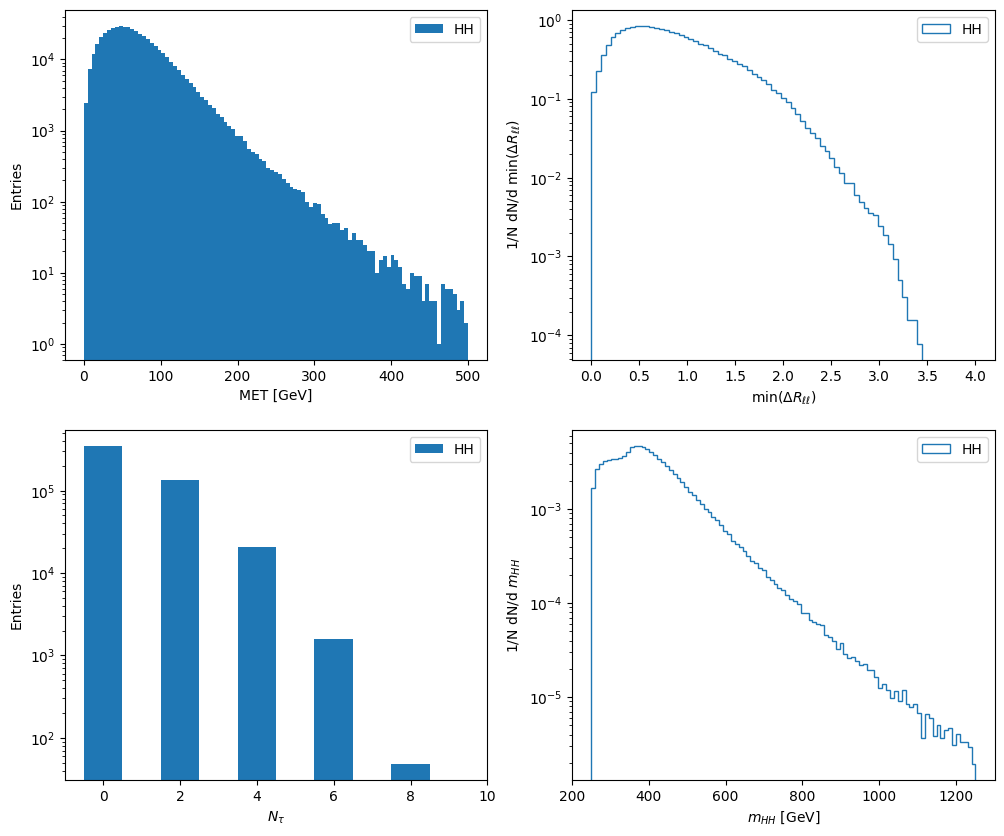

In [18]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
bins=np.linspace(0.,500.,100)
ax[0][0].hist(met_HH,bins=bins,
        histtype='bar',label="HH")
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("MET [GeV]")
ax[0][0].set_ylabel("Entries")
ax[0][0].legend()

bins=np.linspace(0.,4.,80)
ax[0][1].hist(dr_HH,bins=bins,
        histtype='step', density=True,label="HH")
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("min($\\Delta R_{\\ell\\ell})$")
ax[0][1].set_ylabel("1/N dN/d min($\\Delta R_{\\ell\\ell})$")
ax[0][1].legend()

bins=np.linspace(-0.5,9.5,11)
print(bins)
ax[1][0].hist(ntau_HH,bins=bins,
        histtype='bar', density=False,label="HH")
ax[1][0].set_xlabel("$N_{\\tau}$")
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel("Entries")
ax[1][0].legend()

bins=np.linspace(250.,1250.,100)
ax[1][1].hist(mass_HH,bins=bins,
        histtype='step', density=True,label="HH")
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("$m_{HH}$ [GeV]")
ax[1][1].set_ylabel("1/N dN/d $m_{HH}$")
ax[1][1].legend()

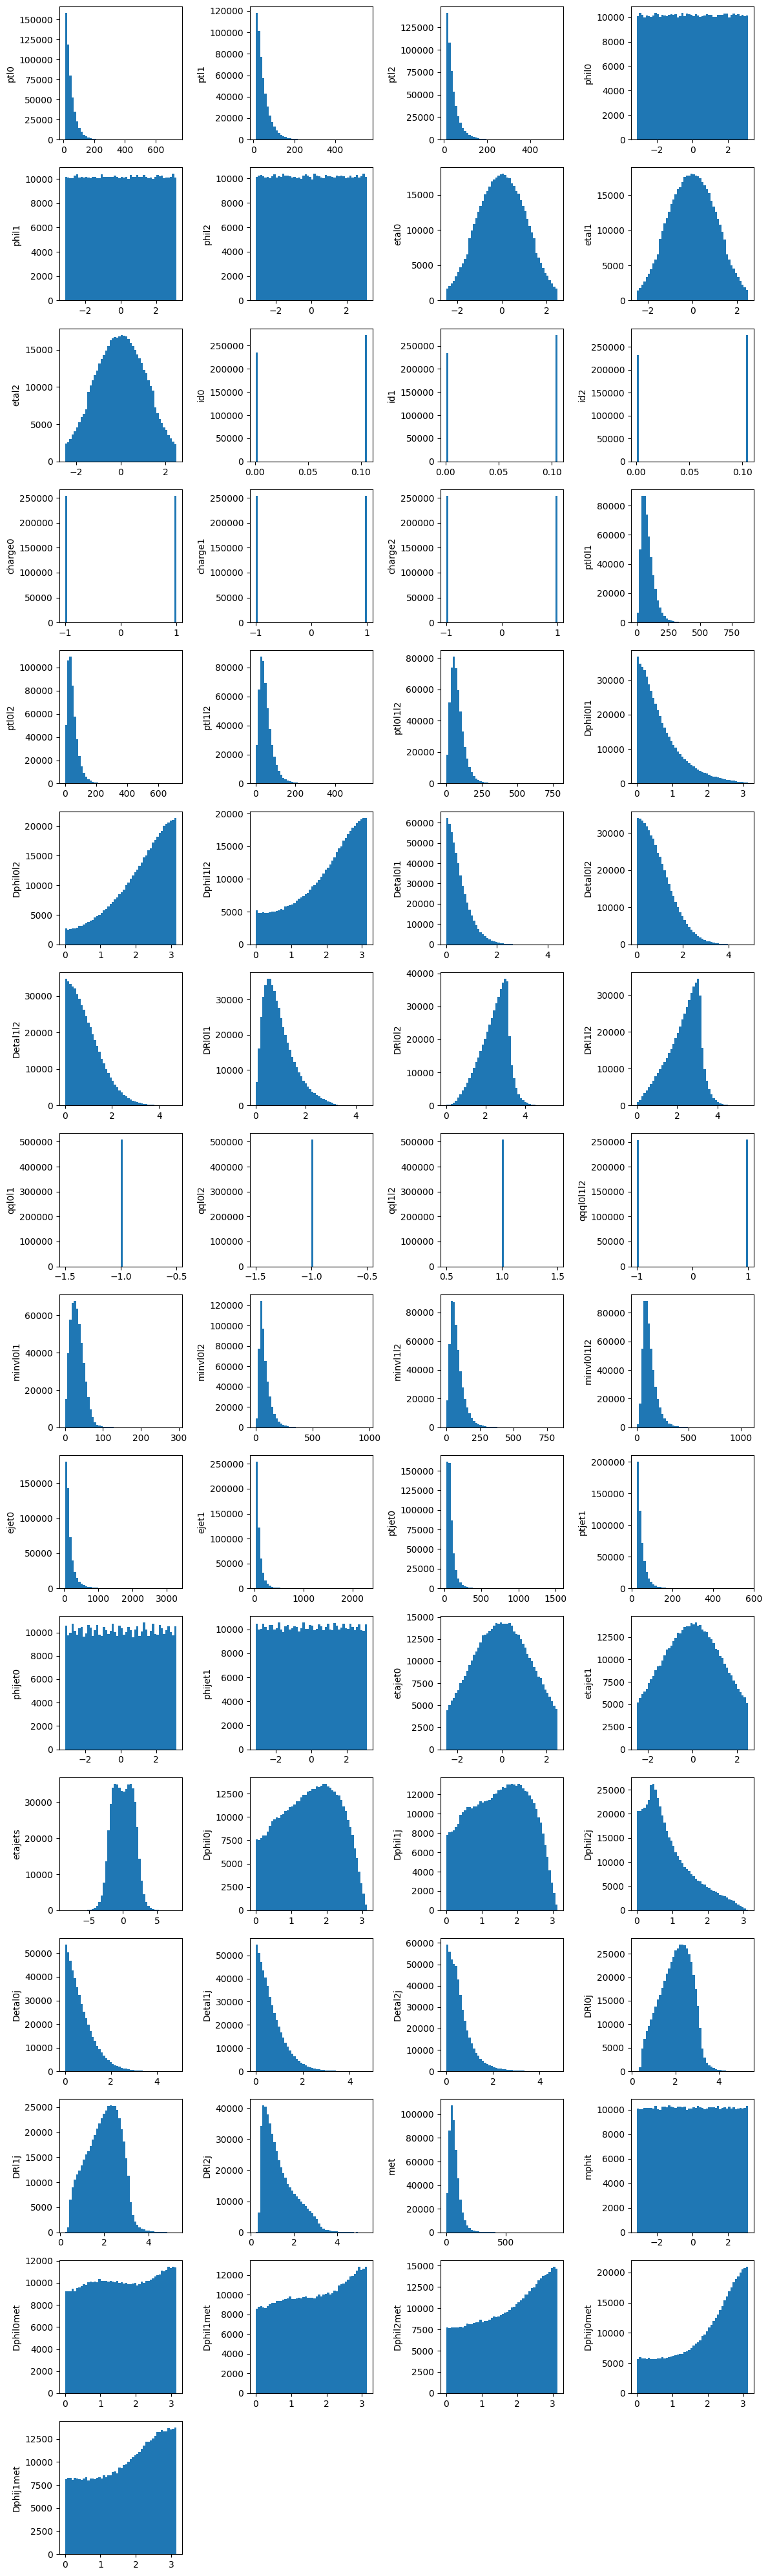

In [33]:
# _, ax = plt.subplots(nrows=8, ncols=8, figsize=(10,10), dpi=150)

# bins = [np.linspace(0,250,40),    np.linspace(0,250,40),    np.linspace(0,250,40),
#     np.linspace(-2.5,2.5,40),    np.linspace(-2.5,2.5,40),    np.linspace(-2.5,2.5,40),
#     np.linspace(-2.5,2.5,40),    np.linspace(-2.5,2.5,40),    np.linspace(-2.5,2.5,40),
#     np.linspace(0,25,26),    np.linspace(0,25,26),    np.linspace(0,5,26),
#     np.linspace(0,1,26),np.linspace(0,1,26),np.linspace(0,1,26),
#     np.linspace(-6,6,50),np.linspace(-1,1,50),np.linspace(-1,.2,10),
#     np.linspace(0,.2,50),np.linspace(-1,.2,26),np.linspace(0,25,26),
#     np.linspace(-200,25,100),np.linspace(-200,25,100),np.linspace(-200,25,100),
#     np.linspace(-60,25,26),np.linspace(0,1,3)]    

plt.figure(figsize=(12,40))
for num, var in enumerate(columns,start=1):
    ax = plt.subplot(16,4,num)
    plt.hist(np.ndarray.flatten(np.array(features[[var]])),bins = 50)
    plt.ylabel(str(var))
    plt.tight_layout()
plt.show()

Scale and prepare as input for the ML algorithm 

Build the benchmark network

Run the model to obtain a benchmark result